## Exploratory Data Storytelling
Pick a dataset (ideally the dataset for your Capstone). If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.

Get going by asking the following questions and looking for the answers with some code and plots:
* Can you count something interesting?
* Can you find some trends (high, low, increase, decrease, anomalies)?
* Can you make a bar plot or a histogram?
* Can you compare two related quantities?
* Can you make a scatterplot?
* Can you make a time-series plot?

Having made these plots, what are some insights you get from them? 
* Do you see any correlations? 
* Is there a hypothesis you would like to investigate further? 
* What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. 
* Is there an interesting narrative that tells a compelling story? 
* What are some other trends/relationships you think will make it more complete?

Submission Requirements: The notebook should contain:

* The questions you asked
* The trends you investigated
* The resulting visualizations and conclusions.

If the data set is too large to commit, please include a link to the data set inside the Jupyter notebook.

In [335]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [336]:
sample = pd.read_csv('story_data.csv')

In [337]:
sample.shape

(1557663, 15)

In [338]:
sample.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,288,8/1/2016 00:01:22,8/1/2016 00:06:11,302,Avenue D & E 3 St,41,-74,428,E 3 St & 1 Ave,41,-74,16920,Subscriber,1961,1
1,457,8/1/2016 00:01:43,8/1/2016 00:09:21,285,Broadway & E 14 St,41,-74,432,E 7 St & Avenue A,41,-74,20084,Subscriber,1989,2
2,278,8/1/2016 00:02:10,8/1/2016 00:06:49,539,Metropolitan Ave & Bedford Ave,41,-74,3096,Union Ave & N 12 St,41,-74,18380,Subscriber,1971,1
3,862,8/1/2016 00:02:13,8/1/2016 00:16:36,280,E 10 St & 5 Ave,41,-74,280,E 10 St & 5 Ave,41,-74,24101,Subscriber,1995,1
4,407,8/1/2016 00:02:21,8/1/2016 00:09:09,161,LaGuardia Pl & W 3 St,41,-74,428,E 3 St & 1 Ave,41,-74,18949,Subscriber,1993,1


In [339]:
pd.options.display.float_format = '{:.0f}'.format

In [340]:
sample['starttime'] = pd.to_datetime(sample['starttime'])

In [341]:
sample['stoptime'] = pd.to_datetime(sample['stoptime'])

In [342]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557663 entries, 0 to 1557662
Data columns (total 15 columns):
tripduration               1557663 non-null int64
starttime                  1557663 non-null datetime64[ns]
stoptime                   1557663 non-null datetime64[ns]
start station id           1557663 non-null int64
start station name         1557663 non-null object
start station latitude     1557663 non-null float64
start station longitude    1557663 non-null float64
end station id             1557663 non-null int64
end station name           1557663 non-null object
end station latitude       1557663 non-null float64
end station longitude      1557663 non-null float64
bikeid                     1557663 non-null int64
usertype                   1557663 non-null object
birth year                 1343039 non-null float64
gender                     1557663 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(5), object(3)
memory usage: 178.3+ MB


In [343]:
sample.isnull().sum()

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  0
end station name                0
end station latitude            0
end station longitude           0
bikeid                          0
usertype                        0
birth year                 214624
gender                          0
dtype: int64

### PART 1 - Define Age Group
This group will make it easier to work with birth year moving forward.  Rather than worry about 100 groups, this will focus on five.  

* **0 UNK**: Those born before 1945
* **1 SEN**: Those who are elderly, born between 1945 - 1960
* **2 ADL**: Those born between 1960 - 1985
* **3 JNR**: Those born between 1985 - 2000
* **4 YNG**: Those born 2000 after

In [347]:
def get_group(row):
    if (row['birth year'] >= 2000):
        return '4 YNG'
    elif (row['birth year'] >= 1985) & (row['birth year'] < 2000):
        return '3 JNR'
    elif (row['birth year'] >= 1960) & (row['birth year'] < 1985):
        return '2 ADL'
    elif (row['birth year'] >= 1945) & (row['birth year'] < 1960):
        return '1 SEN'
    else :
        return '0 UNK'

In [348]:
sample['agegroup'] = sample.apply(get_group, axis=1)

In [349]:
sample.groupby('agegroup').size().sort_values(ascending=False)

agegroup
2 ADL    732540
3 JNR    505780
0 UNK    219878
1 SEN     98826
4 YNG       639
dtype: int64

In [350]:
sample[sample['agegroup'] == '0 UNK'].groupby('birth year').size().sort_index()

birth year
1885     90
1888     36
1893      2
1894      5
1896      8
1899     68
1900    182
1901     60
1907      5
1910     29
1912      2
1913     12
1917     30
1918     27
1920      1
1921     37
1923     22
1926     27
1931      3
1932     46
1933     20
1934     30
1935     89
1936     87
1937     71
1938    337
1939    142
1940    481
1941    818
1942    991
1943    600
1944    896
dtype: int64

### PART 2 - Explore Data before Group
Before exploring information using the group information, let's explore the data as is.

The significant variables are:
* Trip duration (numerical)
* Birth year (categorical)
* User type (categorical, customer or subscriber)
* Gender (categorical, male female or other)
* Start time
* Stop time

Possible explorations include:
* Who: Marginal distribution of gender
* Who: Marginal distribution of user type
* Who: Marginal distribution by age
* When: Histogram of trip durations
* When: Daily count of checkouts by hour
* When: Weekly count of checkouts by day
* How: Trip duration by birth year
* How: Trip duration boxplot by gender
* How: Trip duration boxplot by user type

In [151]:
# WHO / Marginal distributions: This utilizes a histogram or bar chart to show the distribution of records
bar_gender = sample.groupby('gender')['gender'].count()
bar_user = sample.groupby('usertype')['usertype'].size()

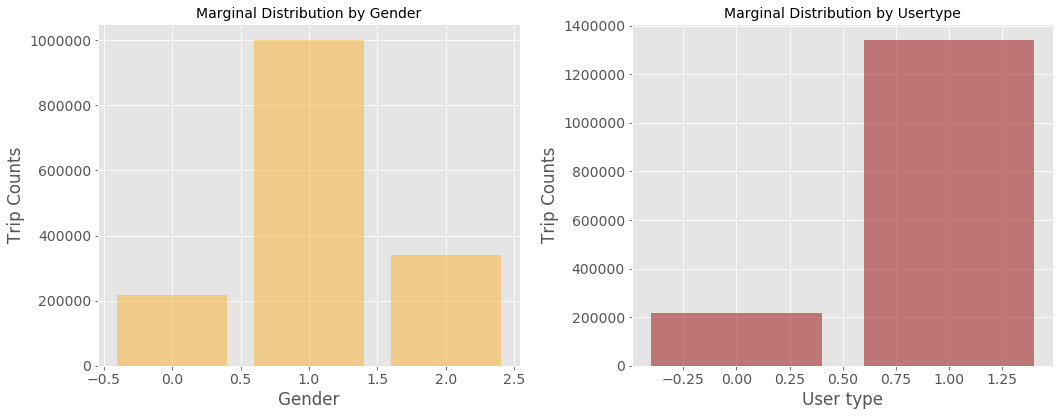

In [186]:
fig, ax = plt.subplots(1,2,figsize=[15,6])

# Marginal distribution by gender
genders = ['none','male','female']
ax[0].bar([0,1,2], bar_gender, align='center', color='orange', alpha=0.4)
ax[0].set_xticks([0,1,2], genders)
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Trip Counts')
ax[0].set_title('Marginal Distribution by Gender', fontsize=14)

# Marginal distribution by user type
users = ['Customers', 'Subscribers']
ax[1].bar([0,1], bar_user, align='center', color='brown', alpha=0.6)
ax[1].set_xticks([0,1], users)
ax[1].set_xlabel('User type')
ax[1].set_ylabel('Trip Counts')
ax[1].set_title('Marginal Distribution by Usertype', fontsize=14)

plt.tight_layout()
plt.show()

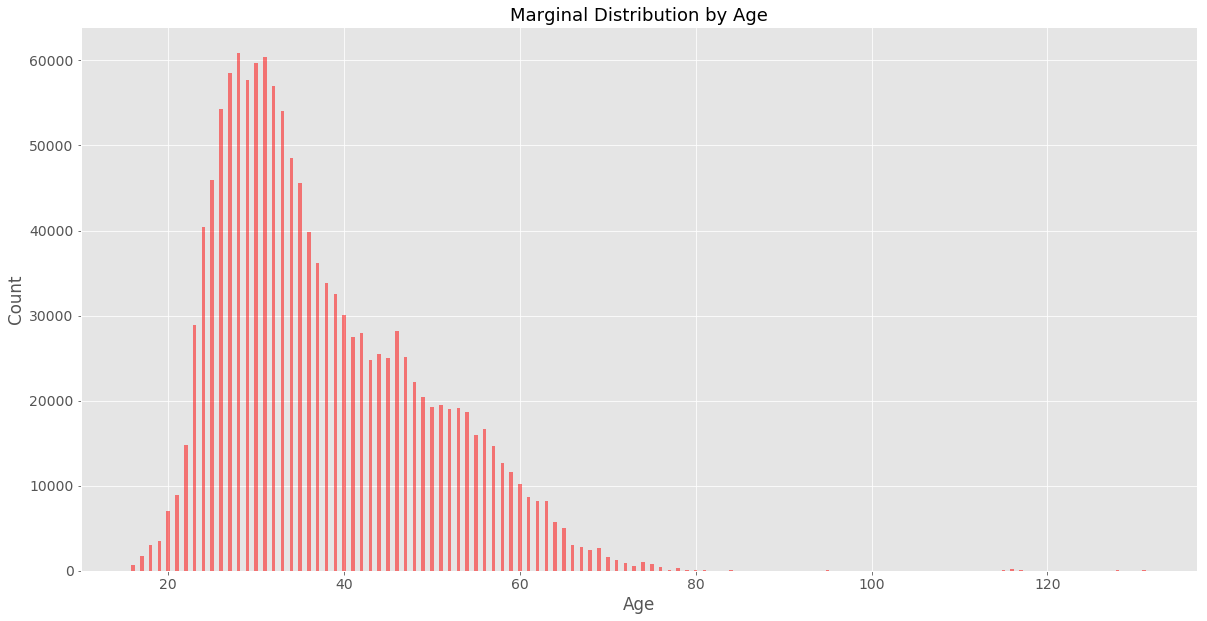

In [183]:
# Marginal distribution by age
age_col = 2016.0 - sample['birth year'].dropna().values
hist_age = np.unique(age_col, return_counts=True)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':14})
plt.bar(hist_age[0], hist_age[1], align='center', color='red', width=0.4, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Marginal Distribution by Age', fontsize=18)
plt.show()

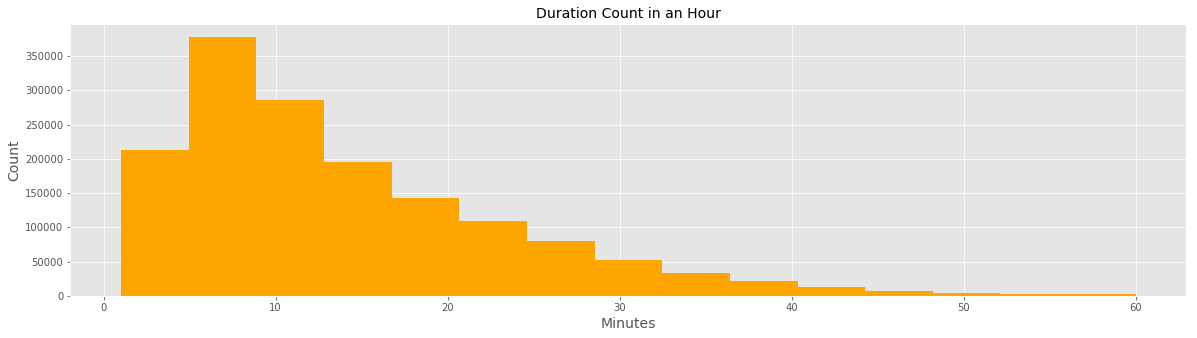

In [322]:
# WHEN / Count by time: Trip count by trip duration, hourly checkout, daily checkout
# Histogram of Trip Duration, shorter than 1 hour
duration_mins = sample.loc[(sample.tripduration / 60 < 60)][['tripduration']] / 60
duration_mins.hist(bins=15, histtype='bar', align='mid', color='orange', figsize=(20,5))

plt.title('Duration Count in an Hour', fontsize=14)
plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Count', fontsize=14)

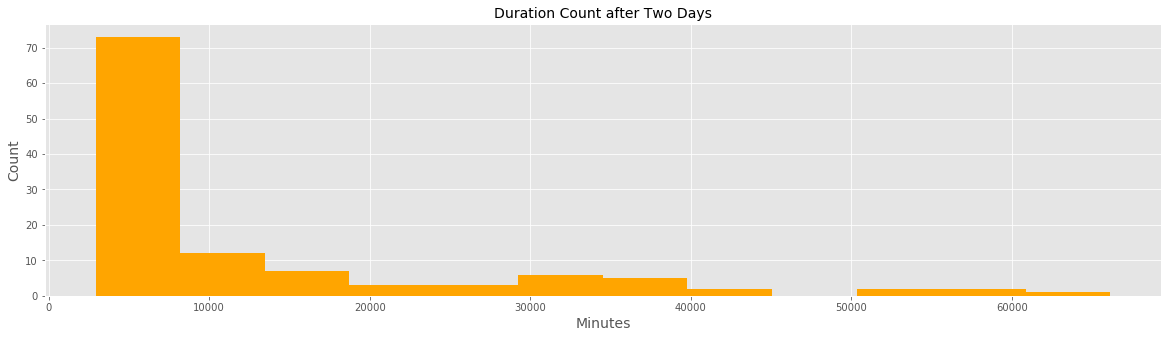

In [323]:
# What about those greater than two days (48 hours)
duration_out = sample.loc[(sample.tripduration / 60 >= (60 * 48))][['tripduration']] / 60
duration_out.hist(bins=12, histtype='bar', align='mid', color='orange', figsize=(20,5))

# This was to look at the outliers (anything over a day is unnormal but data has better outliers)
plt.title('Duration Count after Two Days', fontsize=14)
plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Count', fontsize=14)

In [375]:
# When: Daily count of checkouts by hour
# Weekends and weekdays have different dynamics (i.e. work)
weekday = sample[sample.starttime.dt.weekday < 5]
weekend = sample[sample.starttime.dt.weekday >= 5]
weekday_countsPerHr = weekday.groupby(weekday.starttime.dt.hour).size()
weekend_countsPerHr = weekend.groupby(weekend.starttime.dt.hour).size()

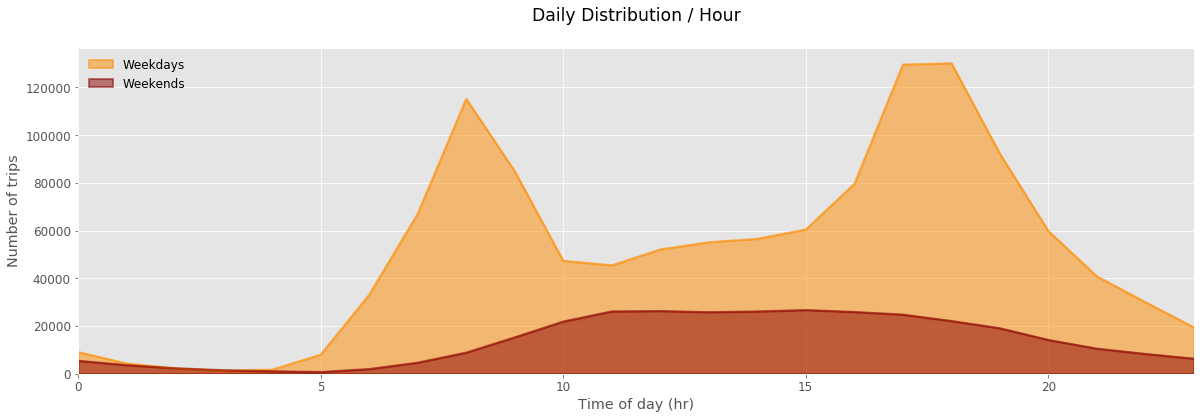

In [383]:
weekday_countsPerHr.plot(kind = 'area', stacked = False, figsize = (20, 6), color = 'darkorange', linewidth = 2, label='Weekdays')
weekend_countsPerHr.plot(kind = 'area', stacked = False, color = 'darkred', linewidth = 2, label='Weekends')

plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.title('Daily Distribution / Hour\n')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = plt.legend(loc='upper left', frameon = False)

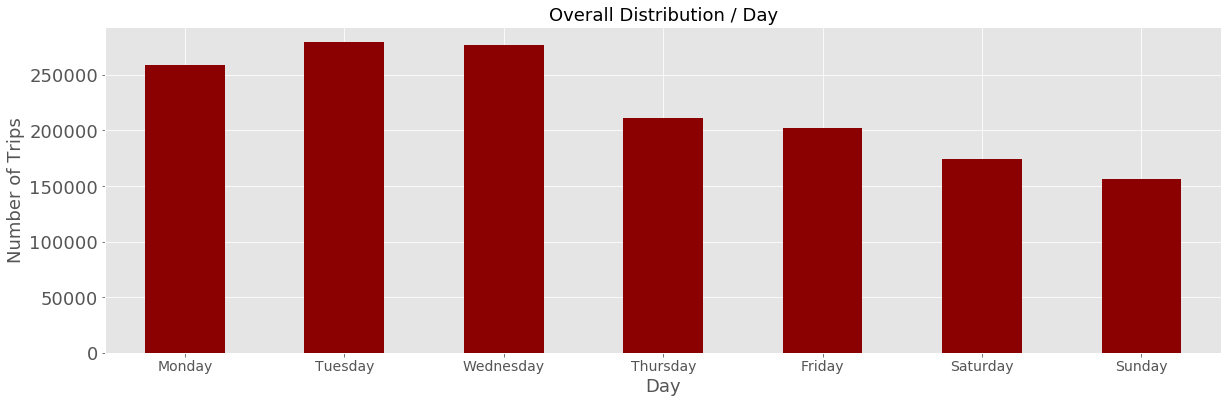

In [407]:
# When: Weekly count of checkouts by day
week_countsPerDay = sample.groupby(sample.starttime.dt.weekday).size()
week_countsPerDay.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_countsPerDay.plot(kind = 'bar', stacked = False, figsize = (20,6), color='darkred', linewidth=2, label='Month')

plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
plt.title('Overall Distribution / Day', fontsize=18)
plt.xticks(rotation=360, fontsize=14)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Number of Trips', fontsize=18)

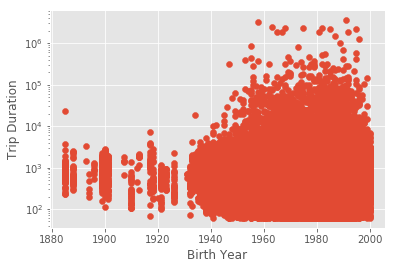

In [43]:
# HOW / Trip Duration by Birth Year: Here a scatterplot is used to compare the trip duration across birth year. 
plt.scatter(sample['birth year'], sample['tripduration'])
plt.xlabel('Birth Year')
plt.ylabel('Trip Duration')
plt.yscale('log')
plt.show()

### PART 3 - Explore Data with Group
In this section, it will explore data with the newly created group type.

The new significant variable is:
* Group type (categorical, five group types)

Possible explorations include:
* Trip duration boxplot by groups (with outliers)
* Trip duration boxplot by groups (without outliers)

In [33]:
count_by_group = sample.groupby('agegroup')['agegroup'].count()
x_pos=[0,1,2,3,4]
agename=['Unknown', 'Seniors', 'Adults', 'Juniors', 'Young']

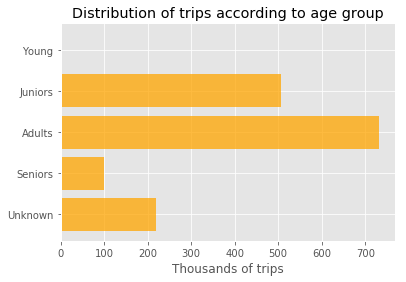

In [34]:
plt.barh(x_pos, count_by_group/1000, align = 'center', alpha = 0.75, color = 'orange')
plt.yticks(x_pos, agename)
plt.xlabel('Thousands of trips')
plt.title('Distribution of trips according to age group')
plt.show()

Notice that majority of the users for this sample range from Junior to Adult (i.e. those born between 1960 to 2000).  This makes sense since this demographic is more active and acceptable to bike sharing.  This will look at trip duration by age group, in a boxplot format.  In this set, the youngest person was born in 2000.  

In [105]:
duration_by_group = sample.groupby('agegroup')['tripduration']
duration_by_group.describe()

,count,mean,std,min,25%,50%,75%,max
agegroup,,,,,,,,
0 UNK,219878,1825,18359,61,813,1256,1700,3966943
1 SEN,98826,903,10905,61,395,645,1079,3189634
2 ADL,732540,836,7134,61,376,608,1010,2497264
3 JNR,505780,836,8068,61,379,618,1019,3565469
4 YNG,639,945,793,62,393,744,1224,6835


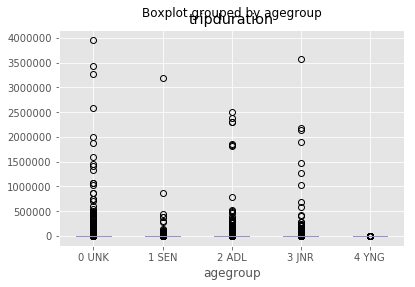

In [119]:
sample.boxplot(column='tripduration',by='agegroup')